In [1]:
import os

In [4]:
# Function to check GPU availability
def check_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available")
        print("Devices:", tf.config.list_physical_devices('GPU'))
    else:
        print("No GPU found, running on CPU")

# EDA


Image Counts:
--------------------------------------------------
Training Flipped: 1162 images
Training Not-Flipped: 1230 images
Testing Flipped: 290 images
Testing Not-Flipped: 307 images
--------------------------------------------------
Total Images: 2989


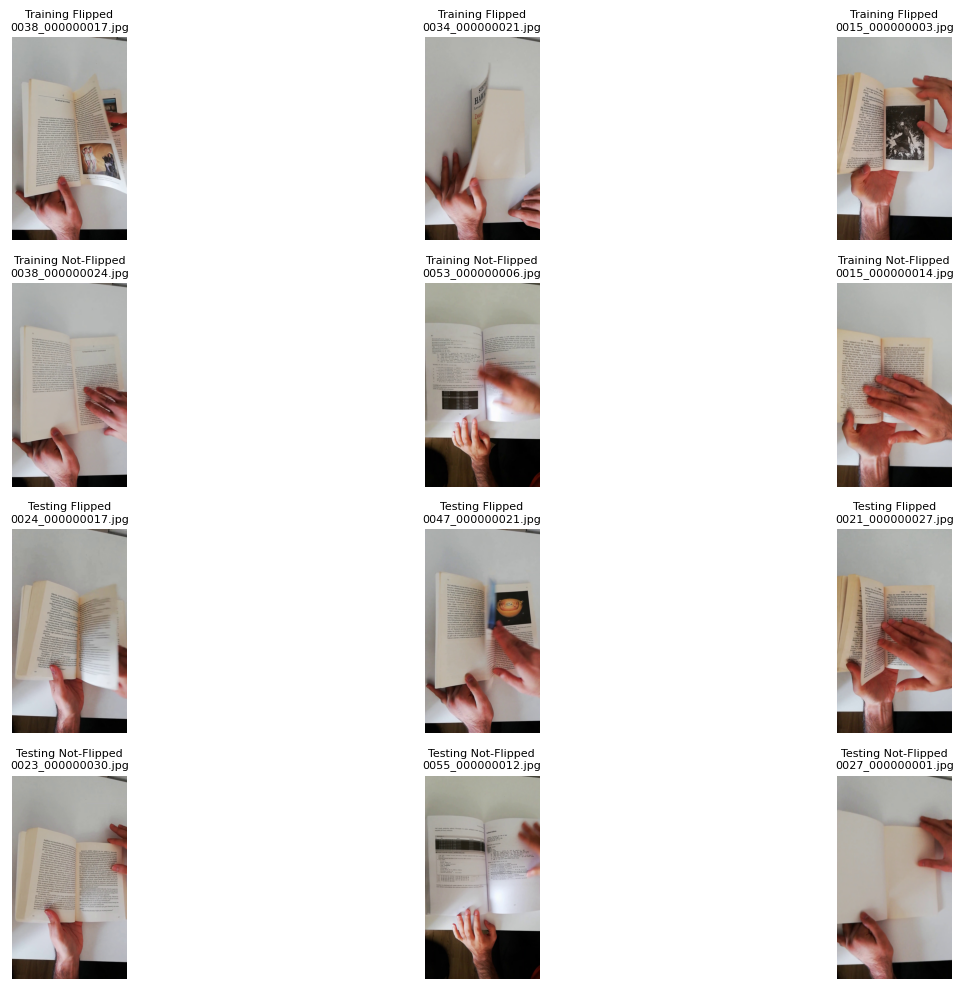


Sample Image Dimensions: (1080, 1920)
Image Mode: RGB

Dataset Split:
Training Set: 2392 images (80.0%)
Testing Set: 597 images (20.0%)

Class Balance:
Flipped: 1452 images (48.6%)
Not-Flipped: 1537 images (51.4%)


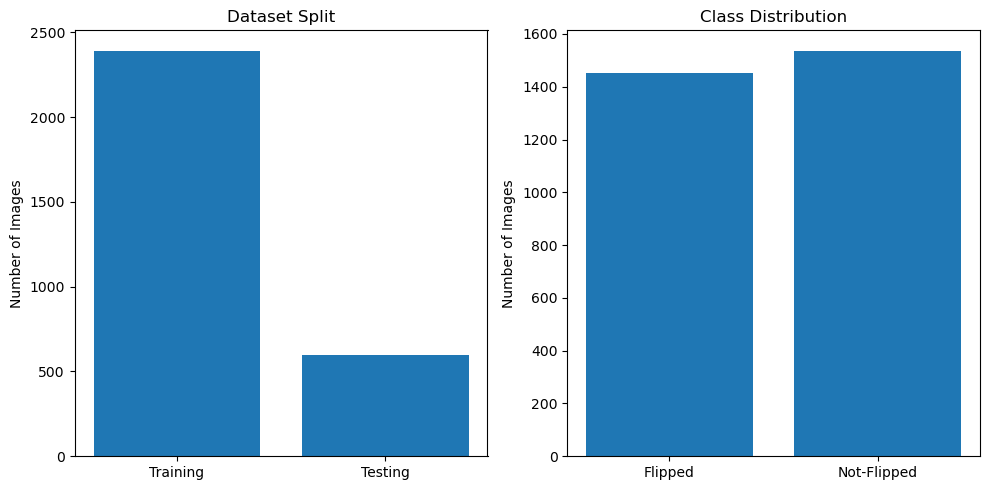

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np

# Define paths
base_dir = 'images'
train_flip_dir = os.path.join(base_dir, 'training', 'flip')
train_nonflip_dir = os.path.join(base_dir, 'training', 'notflip')
test_flip_dir = os.path.join(base_dir, 'testing', 'flip')
test_nonflip_dir = os.path.join(base_dir, 'testing', 'notflip')

# Function to count images in directory
def count_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    return len([f for f in os.listdir(directory) if f.lower().endswith(valid_extensions)])

# Count images in each directory
counts = {
    'Training Flipped': count_images(train_flip_dir),
    'Training Not-Flipped': count_images(train_nonflip_dir),
    'Testing Flipped': count_images(test_flip_dir),
    'Testing Not-Flipped': count_images(test_nonflip_dir)
}

# Print counts
print("\nImage Counts:")
print("-" * 50)
for category, count in counts.items():
    print(f"{category}: {count} images")
print("-" * 50)
total_images = sum(counts.values())
print(f"Total Images: {total_images}")

# Function to display random images from a directory
def show_random_images(directory, num_images=3):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(valid_extensions)]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    images = []
    for file in selected_files:
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)
        images.append((img, file))
    return images

# Display random images from each category
plt.figure(figsize=(15, 10))
categories = [
    (train_flip_dir, 'Training Flipped'),
    (train_nonflip_dir, 'Training Not-Flipped'),
    (test_flip_dir, 'Testing Flipped'),
    (test_nonflip_dir, 'Testing Not-Flipped')
]

for idx, (directory, title) in enumerate(categories):
    images = show_random_images(directory)
    for i, (img, fname) in enumerate(images):
        plt.subplot(4, 3, idx*3 + i + 1)
        plt.imshow(img)
        plt.title(f"{title}\n{fname}", fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

# Get sample image dimensions
sample_img_path = os.path.join(train_flip_dir, os.listdir(train_flip_dir)[0])
with Image.open(sample_img_path) as img:
    print(f"\nSample Image Dimensions: {img.size}")
    print(f"Image Mode: {img.mode}")

# Calculate dataset split percentages
total_train = counts['Training Flipped'] + counts['Training Not-Flipped']
total_test = counts['Testing Flipped'] + counts['Testing Not-Flipped']
print("\nDataset Split:")
print(f"Training Set: {total_train} images ({total_train/total_images*100:.1f}%)")
print(f"Testing Set: {total_test} images ({total_test/total_images*100:.1f}%)")

# Check class balance
print("\nClass Balance:")
print(f"Flipped: {counts['Training Flipped'] + counts['Testing Flipped']} images "
      f"({(counts['Training Flipped'] + counts['Testing Flipped'])/total_images*100:.1f}%)")
print(f"Not-Flipped: {counts['Training Not-Flipped'] + counts['Testing Not-Flipped']} images "
      f"({(counts['Training Not-Flipped'] + counts['Testing Not-Flipped'])/total_images*100:.1f}%)")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Training', 'Testing'], [total_train, total_test])
plt.title('Dataset Split')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.bar(['Flipped', 'Not-Flipped'], 
        [counts['Training Flipped'] + counts['Testing Flipped'],
         counts['Training Not-Flipped'] + counts['Testing Not-Flipped']])
plt.title('Class Distribution')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:")
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Details:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available for training")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, training will use CPU")

# Model parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32  # Adjust based on your GPU memory
EPOCHS = 50

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Replace these paths with your actual data paths
train_generator = train_datagen.flow_from_directory(
    'your_train_data_path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'your_test_data_path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Create model with mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')  # Enable mixed precision

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001
    )
]

# Train with GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=test_generator,
        validation_steps=test_generator.samples // BATCH_SIZE,
        callbacks=callbacks,
        workers=4,  # Adjust based on your CPU cores
        use_multiprocessing=True
    )

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Final evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

ImportError: DLL load failed while importing _imaging: The specified module could not be found.

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                       

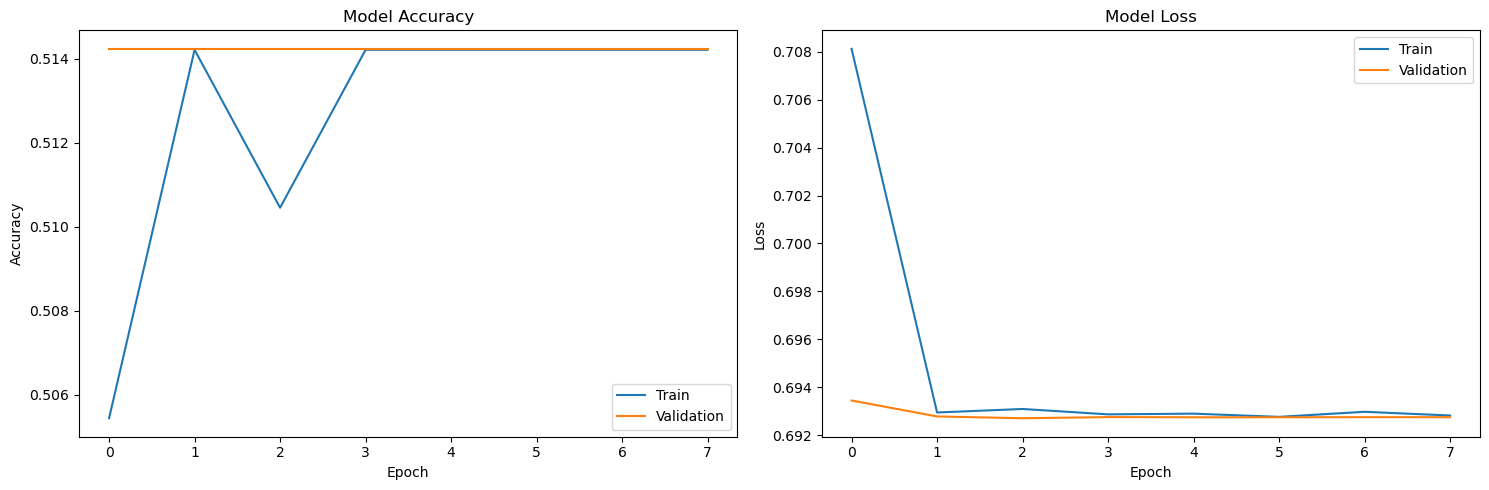

19/19 [==============================] - 9s 455ms/step - loss: 0.6927 - accuracy: 0.5142

Test Accuracy: 51.42%
Test Loss: 0.6927

Prediction Example:


AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [2]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Configuration
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 20

# Directory paths
base_dir = 'images'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['notflip', 'flip']
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['notflip', 'flip']
)

# Build the model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(2, 2),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fourth Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks
)

# Plot training results
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save the final model
model.save('final_model.h5')

# Function to make predictions on a single image
def predict_image(image_path):
    from keras.preprocessing import image
    img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    return prediction[0][0]

# Example of how to use the prediction function
print("\nPrediction Example:")
# Replace with path to your test image
test_image_path = os.path.join(test_dir, 'flip', os.listdir(os.path.join(test_dir, 'flip'))[0])
pred = predict_image(test_image_path)
print(f"Probability of being flipped: {pred:.2f}")

# Created/Modified files during execution:
print("\nCreated files:")
print("- best_model.h5")
print("- final_model.h5")